Model Performance Comparison: All Chutes vs Top 20 Chutes with Issues
Original Model (All Chutes, Hourly Aggregation):
Input Data: Included all chutes over 30 days, grouped by hour.

Problem: The vast majority of records had no performance issues (avg_processing_time_minutes < 10).

Consequence:
The model learned to predict near-zero processing time.
Overfitting to "normal" behavior → Poor at detecting or predicting real problems.
Forecasts were always flat and missed performance spikes.

Refined Model (Top 20 Chutes with Known Issues, 10-Minute Aggregation):
Input Data: Limited to top 20 chutes that had documented performance issues in the past 10 days.

Granularity: Switched to 10-minute intervals to better capture short-term load patterns.

Result:
Model now trains on meaningful variation and real issue patterns.
Reduced noise and class imbalance.
Much better fit for both historical prediction and 6-hour forecasting.
Early results show the model tracks spikes and processing slowdowns more accurately.

Model Version	Data Scope	Granularity	Issue Presence	Prediction Quality
Original (Baseline)	All chutes	Hourly	Mostly 0s	Poor (overfitting)
Refined (Top 20)	Problematic only	10-minutes	Real issues	Improved accuracy


Model 1: Univariate LSTM
Goal: Predict average processing time over time (regression only)
Input: Just one value per 10-minute step: the average processing time (already aggregated)
Use case: Simple trend forecasting — “what will the average be in the next 6 hours?”

Characteristics:
Item	Description
Inputs	1 feature: AVG_PROCESSING_TIME_MINUTES
Target	Same (regression)
Output	One value per time step
Forecast horizon	Next 6 hours (36 × 10-min steps)
Complexity	Simple, fast
Chutes?	No, all chutes are averaged together

Epoch 1/20 - Loss: 0.0140
Epoch 2/20 - Loss: 0.0088
Epoch 3/20 - Loss: 0.0087
Epoch 4/20 - Loss: 0.0088
Epoch 5/20 - Loss: 0.0087
Epoch 6/20 - Loss: 0.0086
Epoch 7/20 - Loss: 0.0085
Epoch 8/20 - Loss: 0.0083
Epoch 9/20 - Loss: 0.0079
Epoch 10/20 - Loss: 0.0082
Epoch 11/20 - Loss: 0.0080
Epoch 12/20 - Loss: 0.0075
Epoch 13/20 - Loss: 0.0073
Epoch 14/20 - Loss: 0.0074
Epoch 15/20 - Loss: 0.0066
Epoch 16/20 - Loss: 0.0063
Epoch 17/20 - Loss: 0.0061
Epoch 18/20 - Loss: 0.0060
Epoch 19/20 - Loss: 0.0062
Epoch 20/20 - Loss: 0.0072


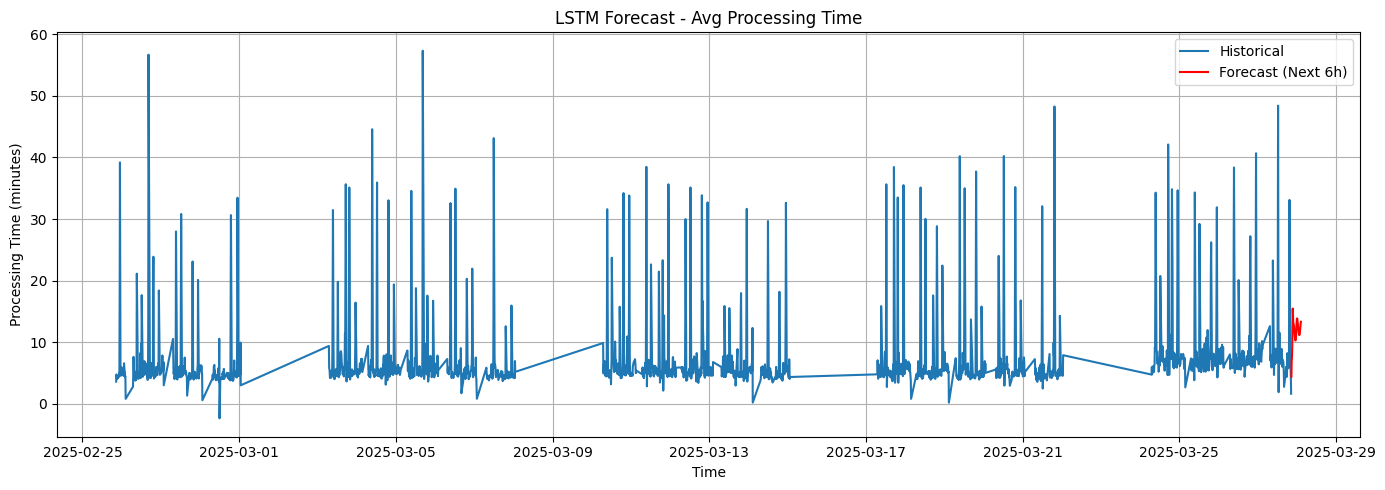

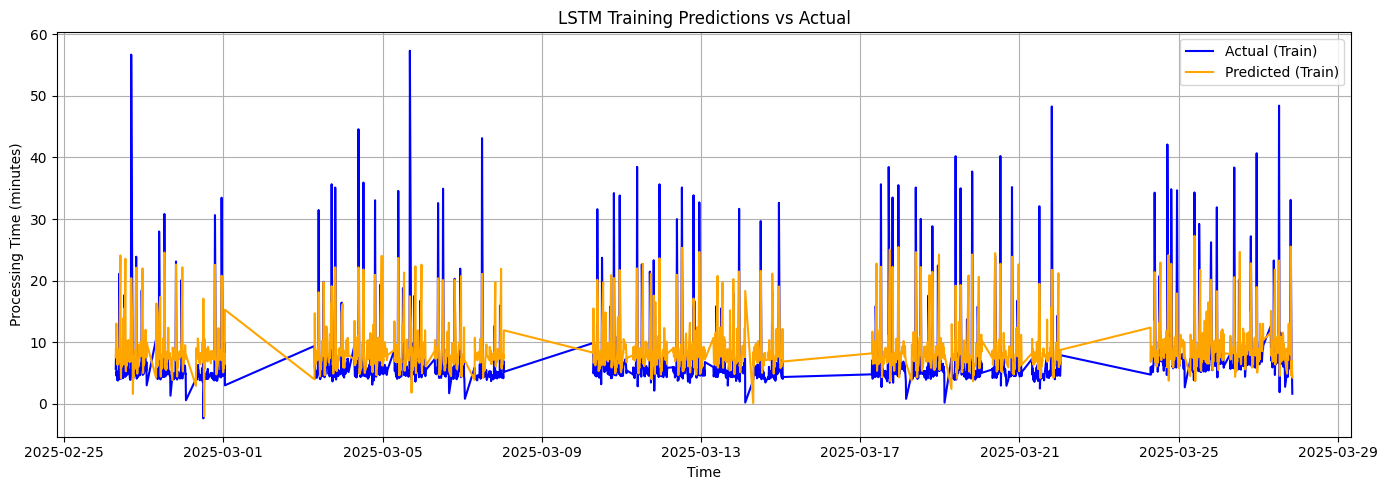

In [14]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# ------------------ LOAD & PREPROCESS ------------------ #
df = pd.read_csv("../DATA/data30daytop20chutezent2.csv")
df['TEN_MIN_TIME'] = pd.to_datetime(df['TEN_MIN_TIME'])

# Use all data
df_filtered = df.copy()

# Group by 10-min time
avg_proc_time = df_filtered.groupby('TEN_MIN_TIME')['AVG_PROCESSING_TIME_MINUTES'].mean().reset_index()
series = avg_proc_time['AVG_PROCESSING_TIME_MINUTES'].values.reshape(-1, 1)

# Normalize
scaler = MinMaxScaler()
scaled_series = scaler.fit_transform(series)

# ------------------ DATASET ------------------ #
class TimeSeriesDataset(Dataset):
    def __init__(self, data, window_size):
        self.data = data
        self.window_size = window_size

    def __len__(self):
        return len(self.data) - self.window_size

    def __getitem__(self, idx):
        x = self.data[idx:idx + self.window_size]       # shape: [seq_len, 1]
        y = self.data[idx + self.window_size]           # shape: [1]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# ------------------ HYPERPARAMETERS ------------------ #
window_size = 36
batch_size = 32
num_epochs = 20
lr = 0.001

dataset = TimeSeriesDataset(scaled_series, window_size)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# ------------------ MODEL ------------------ #
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])  # output: [batch, 1]

device = torch.device("cpu")
model = LSTMModel().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# ------------------ TRAINING ------------------ #
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in dataloader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device).squeeze()

        optimizer.zero_grad()
        output = model(X_batch).squeeze()
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {total_loss / len(dataloader):.4f}")

# ------------------ FORECAST NEXT 6 HOURS ------------------ #
model.eval()
input_seq = torch.tensor(scaled_series[-window_size:], dtype=torch.float32).unsqueeze(0).to(device)  # [1, seq, 1]
future_preds_scaled = []

with torch.no_grad():
    for _ in range(36):
        pred = model(input_seq).squeeze()
        future_preds_scaled.append(pred.item())
        next_input = pred.view(1, 1, 1)
        input_seq = torch.cat((input_seq[:, 1:, :], next_input), dim=1)

# Inverse transform forecast
future_preds = scaler.inverse_transform(np.array(future_preds_scaled).reshape(-1, 1)).flatten()
future_times = pd.date_range(avg_proc_time['TEN_MIN_TIME'].iloc[-1] + pd.Timedelta(minutes=10), periods=36, freq='10min')
forecast_df = pd.DataFrame({'TEN_MIN_TIME': future_times, 'PREDICTED_PROCESSING_TIME_MINUTES': future_preds})

# ------------------ PLOT FORECAST ------------------ #
plt.figure(figsize=(14, 5))
plt.plot(avg_proc_time['TEN_MIN_TIME'], avg_proc_time['AVG_PROCESSING_TIME_MINUTES'], label='Historical')
plt.plot(forecast_df['TEN_MIN_TIME'], forecast_df['PREDICTED_PROCESSING_TIME_MINUTES'], label='Forecast (Next 6h)', color='red')
plt.title("LSTM Forecast - Avg Processing Time")
plt.xlabel("Time")
plt.ylabel("Processing Time (minutes)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ------------------ TRAINING PREDICTIONS ------------------ #
train_preds_scaled = []
input_seq = torch.tensor(scaled_series[:window_size], dtype=torch.float32).unsqueeze(0).to(device)

with torch.no_grad():
    for i in range(window_size, len(scaled_series)):
        pred = model(input_seq).squeeze()
        train_preds_scaled.append(pred.item())
        next_input = torch.tensor(scaled_series[i], dtype=torch.float32).view(1, 1, 1).to(device)
        input_seq = torch.cat((input_seq[:, 1:, :], next_input), dim=1)

train_preds = scaler.inverse_transform(np.array(train_preds_scaled).reshape(-1, 1)).flatten()
actual_train = series[window_size:window_size + len(train_preds)].flatten()
train_times = avg_proc_time['TEN_MIN_TIME'][window_size:window_size + len(train_preds)]

# ------------------ PLOT TRAINING PREDICTIONS ------------------ #
plt.figure(figsize=(14, 5))
plt.plot(train_times, actual_train, label='Actual (Train)', color='blue')
plt.plot(train_times, train_preds, label='Predicted (Train)', color='orange')
plt.title("LSTM Training Predictions vs Actual")
plt.xlabel("Time")
plt.ylabel("Processing Time (minutes)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Model 2: Multivariate Hybrid LSTM
Goal: Predict:

AVG_PROCESSING_TIME_MINUTES (regression)
PERFORMANCE_ISSUE (classification: yes/no)
Input: Rich set of features per time step:
Chute
ZIP code
Load
Package count
Hour of day
Day of week
ZIP count to chute
And more
Use case: Learn complex relationships between features to:
Predict precise performance per chute+zip+hour
Raise alerts if a performance issue is likely

Characteristics:
Item	Description
Inputs	8–10 engineered features per time step
Targets	2: one for regression, one for classification
Output	1 regression value + 1 classification prob
Complexity	Higher – real ML workload
Chutes?	Yes – chute-level predictions

Epoch 01: Loss=1.2119 | MAE=3.23 | Acc=59.54% | Precision=12.77% | Recall=54.63% | F1=20.70%
Epoch 02: Loss=1.2079 | MAE=3.43 | Acc=53.10% | Precision=12.53% | Recall=64.43% | F1=20.98%
Epoch 03: Loss=1.2087 | MAE=3.39 | Acc=52.83% | Precision=12.32% | Recall=63.47% | F1=20.64%
Epoch 04: Loss=1.1995 | MAE=3.26 | Acc=62.17% | Precision=13.65% | Recall=54.74% | F1=21.85%
Epoch 05: Loss=1.1990 | MAE=3.32 | Acc=53.90% | Precision=12.91% | Recall=65.60% | F1=21.57%
Epoch 06: Loss=1.1935 | MAE=3.19 | Acc=58.05% | Precision=13.30% | Recall=60.53% | F1=21.81%
Epoch 07: Loss=1.1956 | MAE=3.37 | Acc=55.81% | Precision=13.08% | Recall=63.32% | F1=21.69%
Epoch 08: Loss=1.1890 | MAE=3.40 | Acc=58.71% | Precision=13.56% | Recall=60.90% | F1=22.18%
Epoch 09: Loss=1.1915 | MAE=3.55 | Acc=55.50% | Precision=13.11% | Recall=64.04% | F1=21.76%
Epoch 10: Loss=1.1923 | MAE=3.46 | Acc=62.59% | Precision=13.75% | Recall=54.48% | F1=21.96%
Epoch 11: Loss=1.1847 | MAE=3.60 | Acc=62.39% | Precision=14.12% | Rec

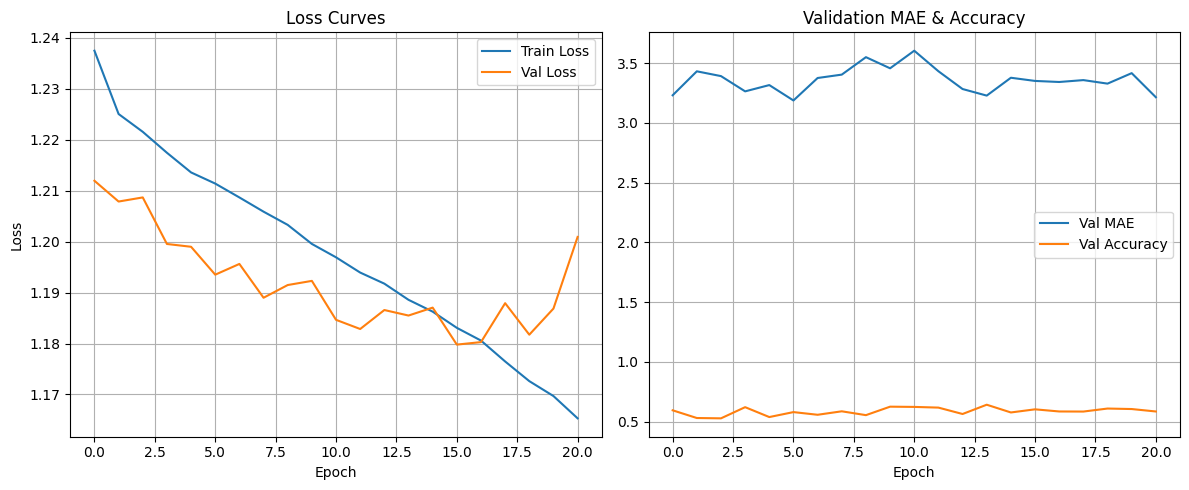

In [17]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt

# ========== LOAD DATA ==========
df = pd.read_csv("../DATA/data30daytop20chutezent2zip.csv")
df['TEN_MIN_TIME'] = pd.to_datetime(df['TEN_MIN_TIME'])

# Encode categorical fields
df['CHUTE'] = df['CHUTE'].astype('category').cat.codes
df['ZIP_CODE'] = df['ZIP_CODE'].astype('category').cat.codes
df = df.sort_values(by=['CHUTE', 'ZIP_CODE', 'TEN_MIN_TIME']).reset_index(drop=True)

# Add derived feature: number of ZIPs per chute per time
df['zip_count_to_chute'] = df.groupby(['CHUTE', 'TEN_MIN_TIME'])['ZIP_CODE'].transform('nunique')

# ========== FEATURES ==========
features = [
    'CHUTE', 'ZIP_CODE', 'PACKAGE_COUNT',
    'CHUTE_LOAD', 'ZIP_PACKAGE_COUNT',
    'HOUR_OF_DAY', 'DAY_OF_WEEK',
    'TEN_MIN_ONLY', 'zip_count_to_chute'
]
target_reg = 'AVG_PROCESSING_TIME_MINUTES'
target_cls = 'PERFORMANCE_ISSUE'

# ========== NORMALIZATION ==========
feature_scaler = MinMaxScaler()
df[features] = feature_scaler.fit_transform(df[features])

target_scaler = MinMaxScaler()
df[[target_reg]] = target_scaler.fit_transform(df[[target_reg]])

# ========== SEQUENCE CREATION ==========
def create_sequences(data, target_reg_idx, target_cls_idx, seq_len=6):
    X, y_reg, y_cls = [], [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len, :-2])
        y_reg.append(data[i+seq_len, target_reg_idx])
        y_cls.append(data[i+seq_len, target_cls_idx])
    return np.array(X), np.array(y_reg), np.array(y_cls)

data = df[features + [target_reg, target_cls]].values
X, y_reg, y_cls = create_sequences(data, len(features), len(features)+1)

X_tensor = torch.tensor(X, dtype=torch.float32)
y_reg_tensor = torch.tensor(y_reg, dtype=torch.float32)
y_cls_tensor = torch.tensor(y_cls, dtype=torch.float32)

# ========== DATASETS ==========
dataset = TensorDataset(X_tensor, y_reg_tensor, y_cls_tensor)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16)

# ========== MODEL ==========
class LSTMHybrid(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc_reg = nn.Linear(hidden_size, 1)
        self.fc_cls = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc_reg(out), self.fc_cls(out)

model = LSTMHybrid(input_size=X.shape[2])
criterion_reg = nn.MSELoss()

# Class imbalance handling
issue_counts = df['PERFORMANCE_ISSUE'].value_counts()
pos_weight = torch.tensor([issue_counts[0] / issue_counts[1]])
criterion_cls = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# ========== TRAINING ==========
train_losses, val_losses = [], []
val_mae_scores, val_acc_scores = [], []
best_val_loss = float("inf")
best_model_state = None
patience = 5
wait = 0

for epoch in range(50):
    model.train()
    total_loss = 0
    for xb, yb_reg, yb_cls in train_loader:
        optimizer.zero_grad()
        out_reg, out_cls_logits = model(xb)
        loss = criterion_reg(out_reg.view(-1), yb_reg) + criterion_cls(out_cls_logits.view(-1), yb_cls)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_losses.append(total_loss / len(train_loader))

    # Validation
    model.eval()
    val_loss = 0
    y_reg_preds, y_cls_preds = [], []
    y_reg_true, y_cls_true = [], []

    with torch.no_grad():
        for xb, yb_reg, yb_cls in val_loader:
            out_reg, out_cls_logits = model(xb)
            loss = criterion_reg(out_reg.view(-1), yb_reg) + criterion_cls(out_cls_logits.view(-1), yb_cls)
            val_loss += loss.item()

            y_reg_preds.extend(out_reg.view(-1).numpy())
            y_cls_preds.extend(torch.sigmoid(out_cls_logits.view(-1)).numpy())
            y_reg_true.extend(yb_reg.numpy())
            y_cls_true.extend(yb_cls.numpy())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    val_mae = mean_absolute_error(
        target_scaler.inverse_transform(np.array(y_reg_true).reshape(-1, 1)),
        target_scaler.inverse_transform(np.array(y_reg_preds).reshape(-1, 1))
    )
    val_acc = accuracy_score(y_cls_true, np.array(y_cls_preds) > 0.5)
    val_precision = precision_score(y_cls_true, np.array(y_cls_preds) > 0.5, zero_division=0)
    val_recall = recall_score(y_cls_true, np.array(y_cls_preds) > 0.5, zero_division=0)
    val_f1 = f1_score(y_cls_true, np.array(y_cls_preds) > 0.5, zero_division=0)

    val_mae_scores.append(val_mae)
    val_acc_scores.append(val_acc)

    print(f"Epoch {epoch+1:02}: Loss={val_loss:.4f} | MAE={val_mae:.2f} | "
          f"Acc={val_acc:.2%} | Precision={val_precision:.2%} | Recall={val_recall:.2%} | F1={val_f1:.2%}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("⏹️ Early stopping triggered.")
            break

# ========== SAVE MODEL ==========
torch.save(best_model_state, "best_lstm_hybrid_10min_zip.pt")
print("✅ Best model saved to best_lstm_hybrid_10min_zip.pt")

# ========== PLOT RESULTS ==========
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(val_mae_scores, label="Val MAE")
plt.plot(val_acc_scores, label="Val Accuracy")
plt.title("Validation MAE & Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


   For each known performance issue in the past, reconstruct the prior sequence and use the model
    to predict whether the issue could have been detected.

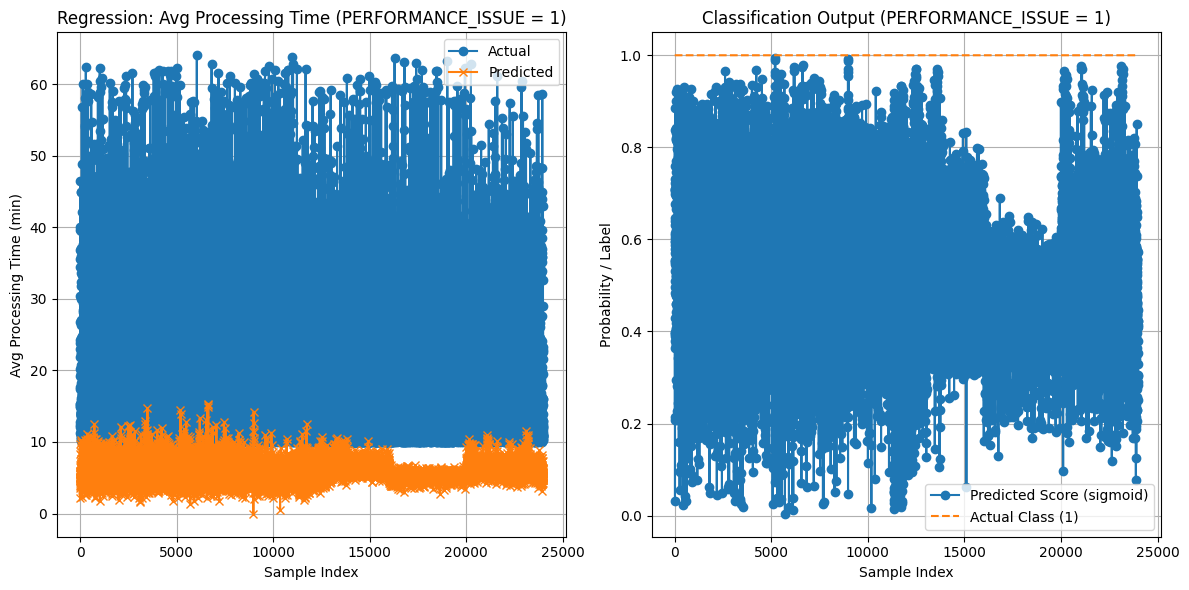

In [47]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# ========== RELOAD AND PREP DATA ==========
df = pd.read_csv("../DATA/data30daytop20chutezent2zip.csv")
df['TEN_MIN_TIME'] = pd.to_datetime(df['TEN_MIN_TIME'])

# Encode CHUTE and ZIP
df['CHUTE'] = df['CHUTE'].astype('category').cat.codes
df['ZIP_CODE'] = df['ZIP_CODE'].astype('category').cat.codes

df = df.sort_values(by=['CHUTE', 'ZIP_CODE', 'TEN_MIN_TIME']).reset_index(drop=True)
df['zip_count_to_chute'] = df.groupby(['CHUTE', 'TEN_MIN_TIME'])['ZIP_CODE'].transform('nunique')

# Feature columns
features = [
    'CHUTE', 'ZIP_CODE', 'PACKAGE_COUNT',
    'CHUTE_LOAD', 'ZIP_PACKAGE_COUNT',
    'HOUR_OF_DAY', 'DAY_OF_WEEK',
    'TEN_MIN_ONLY', 'zip_count_to_chute'
]
target_reg = 'AVG_PROCESSING_TIME_MINUTES'
target_cls = 'PERFORMANCE_ISSUE'

# Normalize
feature_scaler = MinMaxScaler()
df[features] = feature_scaler.fit_transform(df[features])

target_scaler = MinMaxScaler()
df[[target_reg]] = target_scaler.fit_transform(df[[target_reg]])

# Sequence creator
def create_sequences(data, target_reg_idx, target_cls_idx, seq_len=6):
    X, y_reg, y_cls = [], [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len, :-2])
        y_reg.append(data[i+seq_len, target_reg_idx])
        y_cls.append(data[i+seq_len, target_cls_idx])
    return np.array(X), np.array(y_reg), np.array(y_cls)

# Prepare full data
data_full = df[features + [target_reg, target_cls]].values
X_all, y_reg_all, y_cls_all = create_sequences(data_full, len(features), len(features)+1)

# ========== MODEL DEFINITION ==========
class LSTMHybrid(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc_reg = nn.Linear(hidden_size, 1)
        self.fc_cls = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc_reg(out), self.fc_cls(out)

# ========== LOAD MODEL ==========
model = LSTMHybrid(input_size=X_all.shape[2])
model.load_state_dict(torch.load("best_lstm_hybrid_10min_zip.pt"))
model.eval()

# ========== RUN INFERENCE ==========
with torch.no_grad():
    X_all_tensor = torch.tensor(X_all, dtype=torch.float32)
    out_reg_all, out_cls_logits_all = model(X_all_tensor)

y_reg_pred = out_reg_all.view(-1).numpy()
y_cls_pred = torch.sigmoid(out_cls_logits_all.view(-1)).numpy()

# Inverse transform regression output
y_reg_pred_inv = target_scaler.inverse_transform(y_reg_pred.reshape(-1, 1)).flatten()
y_reg_true_inv = target_scaler.inverse_transform(y_reg_all.reshape(-1, 1)).flatten()

# ========== FILTER PERFORMANCE ISSUES ==========
issue_mask = y_cls_all == 1

pred_reg_filtered = y_reg_pred_inv[issue_mask]
true_reg_filtered = y_reg_true_inv[issue_mask]
pred_cls_filtered = y_cls_pred[issue_mask]
true_cls_filtered = y_cls_all[issue_mask]

# ========== PLOT ==========
plt.figure(figsize=(12, 6))

# Regression Plot
plt.subplot(1, 2, 1)
plt.plot(true_reg_filtered, label='Actual', marker='o')
plt.plot(pred_reg_filtered, label='Predicted', marker='x')
plt.title("Regression: Avg Processing Time (PERFORMANCE_ISSUE = 1)")
plt.xlabel("Sample Index")
plt.ylabel("Avg Processing Time (min)")
plt.legend()
plt.grid()

# Classification Confidence
plt.subplot(1, 2, 2)
plt.plot(pred_cls_filtered, label="Predicted Score (sigmoid)", marker='o')
plt.plot(true_cls_filtered, label="Actual Class (1)", linestyle='--')
plt.title("Classification Output (PERFORMANCE_ISSUE = 1)")
plt.xlabel("Sample Index")
plt.ylabel("Probability / Label")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()
